In [1]:
import json
import numpy as np
import torch.nn.functional as F
import os
import sys
import scipy.stats
import matplotlib.pyplot as plt
from pathlib import Path
from multiprocessing import Pool
get_ipython().system = os.system

In [2]:
# Parameters
GPU_ID=0
NUM_THREAD = 8
N=100
A2C_NAME='1201_512'
A2C_T=15000000 # For the skilled dataset
A2C_T=500000 # For the unskilled dataset

NUM_SEED = 1 #100



In [3]:
# Paths
META_DIR_PATH = './data/meta_models'
ENCODER_DIR_PATH = '{}/encoder'.format(META_DIR_PATH)
DATASET_PATH = './data/records/{}.pickle.gzip'.format(A2C_T)

os.environ['GPU_ID'] = str(GPU_ID)
os.environ['N'] = str(N)
os.environ['GPU_ID'] = str(GPU_ID)
os.environ['A2C_NAME'] = str(A2C_NAME)
os.environ['A2C_T'] = str(A2C_T)
os.environ['META_DIR_PATH'] = str(META_DIR_PATH)
os.environ['ENCODER_DIR_PATH'] = str(ENCODER_DIR_PATH)
os.environ['DATASET_PATH'] = str(DATASET_PATH)

# Training and evaluating Encoder and Manifestor

In [7]:
for seed in range(NUM_SEED):
    os.environ['ENCODER_SEED'] = str(seed)
    !bash ./train_encoder.sh
    for mapping in '012 021 102 120 201 210'.split():
        os.environ['MODEL_SEED'] = str(seed + 1000)
        os.environ['MAPPING'] = mapping
        !bash ./train_meta.sh Manifestor

1595 1596
Epoch: 0 (32 %){'loss': 0.0, 'acc0': 0.0, 'acc1': 0.0, 'loss2': 0.00011288085206444567, 'acc_g0': 0.24657012467881964, 'acc_g1': 0.5762637856935015}
Epoch: 0 (64 %){'loss': 0.0, 'acc0': 0.0, 'acc1': 0.0, 'loss2': 6.788982466947668e-05, 'acc_g0': 0.26445142241822106, 'acc_g1': 0.7723323635607063}
Epoch: 0 (96 %){'loss': 0.0, 'acc0': 0.0, 'acc1': 0.0, 'loss2': 5.56265560973995e-05, 'acc_g0': 0.27992912347053944, 'acc_g1': 0.8056790971856845}
Epoch: 0 (test %){'loss': 0.0, 'acc0': 0.0, 'acc1': 0.0, 'loss2': 5.771082341327481e-05, 'acc_g0': 0.3367638582676652, 'acc_g1': 0.8407124576893207}
Epoch: 1 (32 %){'loss': 0.0, 'acc0': 0.0, 'acc1': 0.0, 'loss2': 5.134494190944351e-05, 'acc_g0': 0.2776440485216073, 'acc_g1': 0.8239093025014635}
Epoch: 1 (64 %){'loss': 0.0, 'acc0': 0.0, 'acc1': 0.0, 'loss2': 4.870681944520696e-05, 'acc_g0': 0.276112536194791, 'acc_g1': 0.8358532808163961}
Epoch: 1 (96 %){'loss': 0.0, 'acc0': 0.0, 'acc1': 0.0, 'loss2': 4.3454841029603966e-05, 'acc_g0': 0.2691

# Draw Fig. 3

In [8]:
def softmax(x):
    return np.exp(x) / np.exp(x).sum(axis=1, keepdims=True)

def calc_loss2(g2, r, match_rate):
    cross_entropy_all = list()
    match_rate_all = list()
    for g2_epi, r_epi, match_epi in zip(g2, r, match_rate):
        # calc loss (normalized cross entropy)
        match_epi = np.array(match_epi)
        r_epi = np.array([r_epi[:, i:i+100].sum(axis=1)/20 for i in range(match_epi.shape[0])])
        g0_epi = softmax(r_epi)
        nll = -np.log(g2_epi)
        cross_entropy = nll * g0_epi

        cross_entropy_all.append(cross_entropy)
        match_rate_all.append(match_epi)
    cross_entropy_all = np.vstack(cross_entropy_all)
    match_rate_all = np.hstack(match_rate_all)

    loss = cross_entropy_all.sum(axis=1) / cross_entropy_all.sum()
    loss *= match_rate_all
    loss /= match_rate_all.sum()
    return loss.sum()

In [9]:
DATA_DIR = Path('./data/meta_models/goal_loss'.format(A2C_T))
def process(seed):
    translaters = '012 021 102 120 201 210'.split()
    results_in_seed = dict()
    accuracies = dict()
    for translater in translaters:
        with (DATA_DIR/'{}_{}.json'.format(seed, translater)).open() as f:
            data_original = json.load(f)
        data =  {key: np.array([line[key] for line in data_original]) for key in ['g0','g1', 'g2', 'r_']}
        data['match_rate'] = [line['match_rate'] for line in data_original]
        results_in_seed[translater] = data
        accuracies[translater] = (data['g1'].reshape(-1) == data['g2'].reshape((-1, 3)).argmax(axis=1)).mean()
        
    best_mapping, best_accuracy = max(accuracies.items(), key = lambda x:x[1])
    # for debug only
    # return best_mapping
    trans = str.maketrans({num: char for char, num in zip('ABC', best_mapping)})

    losses = dict()
    for translater, data in results_in_seed.items():
        order = translater.translate(trans)
        loss = calc_loss2(data['g2'], data['r_'], data['match_rate'])
        losses[order] = loss
    ratio = np.array([losses[key] / losses['ABC'] for key in 'ACB BAC BCA CAB CBA'.split()])
    n_win = (ratio > 1).sum()
    return n_win, ratio, best_accuracy, best_mapping

with Pool(NUM_THREAD) as p:
    rtn = p.map(process, range(NUM_SEED))

In [10]:
threshold = 0
n_win = [l[0] for l in rtn if l is not None]
ratios = [l[1] for l in rtn if l is not None]
accuracies = [l[2] for l in rtn if l is not None]
best_mappings = [l[3] for l in rtn if l is not None]
assert len(n_win) == NUM_SEED

with (Path(META_DIR_PATH)/'best_mappings.txt').open('w') as f:
    f.write(' '.join(best_mappings))

n_total = len(ratios) * 5

ratios = np.array(ratios)

[1. 2. 5. 3. 4.]
[1.11782217 1.14578562 1.28703156 1.17042899 1.17878085]
[1.11782217 1.14578562 1.28703156 1.17042899 1.17878085]
[1.11782217 1.14578562 1.28703156 1.17042899 1.17878085]
{'threshold': 0, 'n_win': 5, 'n_total': 5, 'percentage': 1.0, 'min': 1.1178221656039933, 'max': 1.2870315584832708, 'mean': 1.1799698363146427, 'std': 0.05759435250470573, 'median': 1.1704289852706822}


/home/fu/.local/share/virtualenvs/dqn_lunar_D-vEW6w6XU/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/home/fu/.local/share/virtualenvs/dqn_lunar_D-vEW6w6XU/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


(1.0670869796925153, 1.29285269293677)

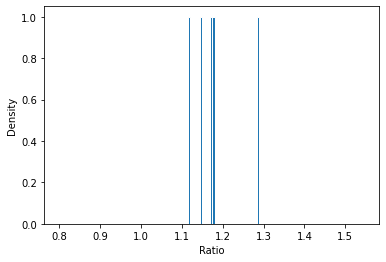

In [11]:
class MyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(MyEncoder, self).default(obj)
print(ratios.argsort(axis=1).argsort(axis=1).mean(axis=0) + 1)
print(ratios.mean(axis=0))
print(ratios.min(axis=0))
print(ratios.max(axis=0))

statistics = dict(
    threshold=threshold,
    n_win=sum(n_win),
    n_total=n_total,
    percentage=sum(n_win)/n_total,
    min=ratios.min(),
    max=ratios.max(),
    mean=ratios.mean(),
    std=ratios.std(),
    median=np.median(ratios)
)
print(statistics)

plt.figure(figsize=(6,4))
plt.hist([ratios[ratios<1], ratios[ratios>=1]], histtype='barstacked', bins=np.arange(0.8, 1.55, 0.005),  ec='white', color=['tab:red','tab:blue'])
plt.xlabel('Ratio')
plt.ylabel('Density')
plt.savefig(DATA_DIR/'hist_{}.pdf'.format(A2C_T))
with (DATA_DIR/'hist_{}_stats.json'.format(A2C_T)).open('w') as f:
    json.dump(statistics, f, cls=MyEncoder)

scipy.stats.norm.interval(alpha=.95, loc=ratios.mean(), scale=ratios.std())

# TRAINING ablation and optimal

In [12]:
for seed, mapping in zip(range(NUM_SEED), best_mappings):
    os.environ['ENCODER_SEED'] = str(seed)
    os.environ['MODEL_SEED'] = str(seed + 1000)
    os.environ['MAPPING'] = mapping
    !bash ./train_meta.sh ablation
    !bash ./train_meta.sh optimal

257812 244823
Epoch: 0 (25 %), order: [2, 0, 1]{'loss': 0.0020820292415025185, 'acc0': 0.4740513392857143, 'acc1': 0.4758959573412698, 'loss2': 0.006402137650904204, 'acc_g0': 0.3232576884920635, 'acc_g1': 0.9295014880952381}
Epoch: 0 (50 %), order: [2, 0, 1]{'loss': 0.0018873854541865767, 'acc0': 0.52704087972167, 'acc1': 0.5761835238568589, 'loss2': 0.0074193388455188695, 'acc_g0': 0.3248322564612326, 'acc_g1': 0.9296253727634195}
Epoch: 0 (75 %), order: [2, 0, 1]{'loss': 0.0018771060790749709, 'acc0': 0.5251615308151093, 'acc1': 0.5746458747514911, 'loss2': 0.007525441750114617, 'acc_g0': 0.3251428926441352, 'acc_g1': 0.9274353876739563}
Epoch: 0 (100 %), order: [2, 0, 1]{'loss': 0.0018482766568310813, 'acc0': 0.5212630467196819, 'acc1': 0.579087972166998, 'loss2': 0.0076241552051635846, 'acc_g0': 0.3245682157057654, 'acc_g1': 0.9282275099403579}
Epoch: 0 (test %), order: [2, 0, 1]{'loss': 0.0018406970178733032, 'acc0': 0.4834104638861545, 'acc1': 0.5972600613504451, 'loss2': 0.0089

# Draw Fig. 4

In [13]:
NUM_OPTIMAL = 5
optimals = sorted((Path(META_DIR_PATH)/'optimal').glob('*'), key=lambda p: int(p.name))[:NUM_OPTIMAL]
optimals = [str(list(p.glob('**/Transformer_state_seqlast19.pt'))[0]) for p in optimals]

os.environ['TEACHER_PATHS'] = ';'.join(optimals)
for seed, mapping in zip(range(NUM_SEED), best_mappings):
    os.environ['ENCODER_SEED'] = str(seed)
    os.environ['MODEL_SEED'] = str(seed + 1000)
    os.environ['MAPPING'] = mapping
        
    !bash ./eval_meta.sh Manifestor
    !bash ./eval_meta.sh ablation


./data/meta_models/Manifestor/0/201/1000/Transformer_state_seqlast19.pt ./data/meta_models/Manifestor/comparison data/meta_models/optimal/0/201/1000/Transformer_state_seqlast19.pt
./data/meta_models/ablation/0/201/1000/Transformer_state_seqlast19.pt ./data/meta_models/ablation/comparison data/meta_models/optimal/0/201/1000/Transformer_state_seqlast19.pt


In [14]:
def load_data(target):
    assert target in ['ablation', 'Manifestor']
    comparison_data_dir = Path(META_DIR_PATH)/target/'comparison'
    data = [np.load(comparison_data_dir/'{}_{}.npz'.format(i, mapping)) for i, mapping in enumerate(best_mappings)]
    return data

def calc_acc(ys, ts):
    t_labels = ts.mean(axis=1).argmax(axis=1)
    y_labels = ys.argmax(axis=1)
    n = ys.shape[0]
    return (t_labels == y_labels).sum() / n

acc_manifestor = np.array([calc_acc(**line) for line in load_data('Manifestor')])
acc_ablation = np.array([calc_acc(**line) for line in load_data('ablation')])

In [15]:
load_data('Manifestor')[0]['ys'], load_data('Manifestor')[0]['ts']

(array([[1.02379963e-04, 4.24365280e-04, 9.99473274e-01],
        [1.04135717e-04, 3.77798628e-04, 9.99518037e-01],
        [1.06602914e-04, 3.40758124e-04, 9.99552548e-01],
        ...,
        [4.00026351e-01, 2.84857731e-02, 5.71487844e-01],
        [3.96173954e-01, 2.96990592e-02, 5.74127018e-01],
        [3.91009659e-01, 3.10716089e-02, 5.77918649e-01]], dtype=float32),
 array([[[1.44580499e-05, 3.48639727e-01, 6.51345849e-01]],
 
        [[1.23336267e-05, 1.98245868e-01, 8.01741779e-01]],
 
        [[9.97751704e-06, 1.02257416e-01, 8.97732675e-01]],
 
        ...,
 
        [[5.30979651e-06, 1.69221443e-04, 9.99825418e-01]],
 
        [[5.29400177e-06, 1.70091269e-04, 9.99824703e-01]],
 
        [[5.27844759e-06, 1.70427666e-04, 9.99824345e-01]]], dtype=float32))

In [16]:
def print_stats(l):
    print(
        l.mean(),
        l.std(),
        l.min(),
        l.max(),
        np.median(l)
    )

print_stats(acc_ablation)
print_stats(acc_manifestor)
print(scipy.stats.mannwhitneyu(acc_ablation, acc_manifestor))

0.5595919124131163 0.0 0.5595919124131163 0.5595919124131163 0.5595919124131163
0.8234469472570309 0.0 0.8234469472570309 0.8234469472570309 0.8234469472570309
MannwhitneyuResult(statistic=0.0, pvalue=1.0)


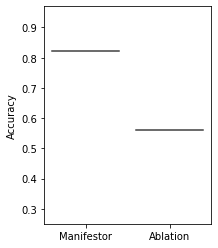

In [17]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(3,4))
df = pd.DataFrame(
    
    [['manifestor', line] for line in acc_manifestor] + [['ablation', line] for line in acc_ablation],
    columns=['type', 'accuracy'])
palette=(sns.color_palette()[0], sns.color_palette()[2])
sns.boxenplot(x='type', y='accuracy', data=df, ax=ax, palette=palette)
ax.set_ylabel('Accuracy')
ax.set_ylim([0.25,0.97])
ax.set_xlabel('')
ax.set_xticklabels(['Manifestor', 'Ablation'])
plt.savefig('{}/B-2.pdf'.format(META_DIR_PATH))

In [18]:
print(scipy.stats.norm.interval(alpha=.95, loc=acc_manifestor.mean(), scale=acc_manifestor.std()))
print(scipy.stats.norm.interval(alpha=.95, loc=acc_ablation.mean(), scale=acc_ablation.std()))

(nan, nan)
(nan, nan)


/home/fu/.local/share/virtualenvs/dqn_lunar_D-vEW6w6XU/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2128: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/fu/.local/share/virtualenvs/dqn_lunar_D-vEW6w6XU/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2129: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
